# Fitting truncated Gaussians

In [1]:
from scipy import stats
import scipy.sparse
import numpy as np
import maxentropy

In [2]:
whichplot = 2  # sub-plot in Figure 6.1 (0 , 1 , or 2)
d = 1     # number of dimensions
m = d*3   # number of features

In [3]:
# Bounds
o = np.ones(d)
if whichplot == 0:
    lower = -2.5 * o
    upper = -lower
elif whichplot == 1:
    lower = 0.5 * o
    upper = 2.5 * o
elif whichplot == 2:
    lower = -0.1 * o
    upper = 0.1 * o

In [4]:
def f0(x):
    return x

In [5]:
def f1(x):
    return x**2

In [6]:
def f2(x):
    return (lower < x) & (x < upper)

In [7]:
f = [f0, f1, f2]

In [8]:
# Target constraint values
b = np.empty (m , float )
if whichplot == 0:
    b [0: m :3] = 0   # expectation
    b [1: m :3] = 1   # second moment
    b [2: m :3] = 1   # truncate completely outside bounds
elif whichplot == 1:
    b [0: m :3] = 1.0 # expectation
    b [1: m :3] = 1.2 # second moment
    b [2: m :3] = 1   # truncate completely outside bounds
elif whichplot == 2:
    b [:] = [0. , 0.0033 , 1]

In [9]:
b

array([ 0.    ,  0.0033,  1.    ])

Create a generator of features of random points under a Gaussian auxiliary dist $q$ with diagonal covariance matrix.

In [10]:
from scipy.stats import norm

In [11]:
mu = b[0]
sigma = (b[1] - mu**2)**0.5
mu, sigma

(0.0, 0.057445626465380289)

In [12]:
auxiliary = stats.norm(loc=mu, scale=sigma)

In [13]:
auxiliary

In [14]:
from maxentropy.maxentutils import auxiliary_sampler_scipy

In [41]:
sampler = auxiliary_sampler_scipy(auxiliary, n=10**5)

In [42]:
xs, log_q_xs = sampler()

In [43]:
xs.shape, log_q_xs.shape

((1, 100000), (100000,))

In [44]:
xs[0, :10]

array([ 0.05450201, -0.0394257 ,  0.09740581,  0.1205572 , -0.06662786,
        0.04797003,  0.00822622, -0.01663842, -0.07285212, -0.06543732])

In [45]:
features = maxentropy.bigmodel.vec_feature_function(f, sparse=False)
F1 = features(xs)
xs, F1

(array([[ 0.05450201, -0.0394257 ,  0.09740581, ...,  0.01175197,
          0.10218522,  0.10200736]]),
 array([[  5.45020093e-02,  -3.94257020e-02,   9.74058079e-02, ...,
           1.17519668e-02,   1.02185219e-01,   1.02007358e-01],
        [  2.97046902e-03,   1.55438598e-03,   9.48789140e-03, ...,
           1.38108724e-04,   1.04418189e-02,   1.04055010e-02],
        [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
           1.00000000e+00,   0.00000000e+00,   0.00000000e+00]]))

We pass `auxiliary_sampler` as a generator function that will be used for importance sampling. This yields a tuple `(log_q_xs, xs)` whose dimensions are `(n,)` and `(d, n)`.

We also pass `features` as a vectorized function that operates on each vector of samples xs = `[x_1,...,x_n]`.

In [49]:
model = maxentropy.BigModel(sampler)   # create a model
#model.verbose=True
model.fit(f, b)

In [ ]:
%%timeit
model.resetparams(len(f))
#model.sparse = True
model.fit(f, b)                    # fit under the given constraints using SPO

In [30]:
model.iters, model.fnevals

(43, 325)

After running this code, the `model` has a vector
of parameters $\theta = (\theta_i)^{3d}_{i=1}$
stored as the array `model.params`. The pdf of the fitted model can then be retrieved
with the `model.pdf` method and plotted as follows:



In [31]:
%matplotlib inline

(0, 5.5459995550535863)

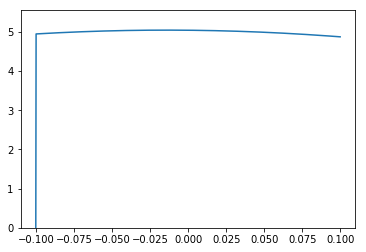

In [32]:
# Plot the marginal pdf in dimension 0 , letting x_d =0
# for all other dimensions d.
xs = np.arange(lower[0], upper[0], (upper[0] - lower[0]) / 1000.)
all_xs = np.zeros((d , len(xs)), float)
all_xs[0, :] = xs
pdf = model.pdf(model.features(all_xs))

import matplotlib.pyplot as plt
plt.plot(xs, pdf)
plt.ylim(0, pdf.max()*1.1)

In [33]:
model.expectations()

array([  2.05121524e-08,   3.30004396e-03,   9.99999946e-01])

In [34]:
b

array([ 0.    ,  0.0033,  1.    ])

In [39]:
np.allclose(model.expectations(), b, atol=1e-6)

True